# Evaluate and fit a ML model on the EC flux tower data 



## Load modules

In [1]:
import os
import shap
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sb
from joblib import dump
import multiprocessing
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV#, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.classification import spatial_clusters, SKCV

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_name = 'AUS'
model_var = 'NEE'

In [3]:
ncpus=multiprocessing.cpu_count()
print('ncpus = '+str(ncpus))

ncpus = 16


## Prepare Data

In [4]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        td.append(xx)

## Modelling

In [5]:
xx = []
yy = []
cc = []
for t in td:
    # t = t.drop('PFT_RS', axis=1)
    t = t.dropna()  # remove NaNS
    coords = t[['x_coord','y_coord']] #extract coords
    t = t.drop(['x_coord','y_coord','PFT_RS'] , axis=1) # drop coords and Landcover
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    df = df.filter(regex='RS') # only use remote sensing variables   
    
    # Write out predictior variables to text file
    textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "w")
    for element in df.columns:
        textfile.write(element + ",")
    textfile.close()
    
    if model_var == 'ET':
        df_var=t[model_var+'_EC']
    else:
        df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling

    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    c = coords.reset_index(drop=True)
    xx.append(x)
    yy.append(y)
    cc.append(c)
    
x = np.concatenate([x for x in xx])
y = np.concatenate([y for y in yy])
c = np.concatenate([c for c in cc])

print(x.shape)

(2797, 16)


## Test model robustness with nested spatial k-fold cross validation

In [11]:
inner_cv_splits = 5

outer_cv_splits = 7

test_size = 0.20

cluster_method = 'Hierarchical'

max_distance = 0.05 # map degrees

n_clusters=25

kfold_method = 'SpatialShuffleSplit'

balance = 10

### Visualising spatial groupings

After setting the parameters, lets first generate spatial clusters using the DE Africa function spatial_clusters to visualize how our data will be grouped when running SKCV in the next step. You may want to refine the parameters to achieve a grouping that works for your dataset by resetting the parameters above


In [7]:
aus=gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/aus_outline/AUS_2021_AUST_GDA2020.shp')

n clusters = 26


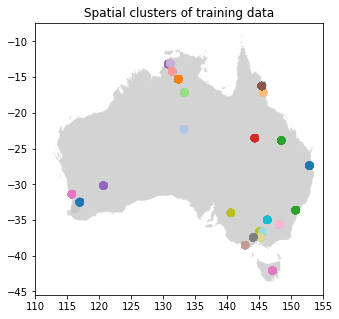

In [8]:
#create clustes
spatial_groups = spatial_clusters(coordinates=c,
                                  method=cluster_method,
                                  max_distance=max_distance,
                                  n_groups=n_clusters,
                                  verbose=True)

#plot
fig, ax = plt.subplots(1,1, figsize=(9,5))
aus[aus.AUS_CODE21=='AUS'].plot(ax=ax, color='lightgrey')
ax.scatter(c[:, 0], c[:, 1], c=spatial_groups,
            s=50, cmap='tab20');
ax.set_xlim(110,155)
plt.title('Spatial clusters of training data');

In [12]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ["squared_error", "absolute_error"],
    'max_features': [1.0, 'log2', None],
    'n_estimators': [100,200,300,400]
}

In [13]:
# create outer k-fold splits
outer_cv = SKCV(
    coordinates=c,
    max_distance=max_distance,
    n_splits=outer_cv_splits,
    cluster_method=cluster_method,
    kfold_method=kfold_method,
    test_size=test_size,
    balance=balance,
)

# lists to store results of CV testing
acc = []
rmse=[]
r2=[]
i = 1
for train_index, test_index in outer_cv.split(c):
    print(f"Working on {i}/{outer_cv_splits} outer cv split", end='\r')
    model = RandomForestRegressor(random_state=1, n_jobs=ncpus)

    # index training, testing, and coordinate data
    X_tr, X_tt = x[train_index, :], x[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    coords = c[train_index]
    
    # inner split on data within outer split
    inner_cv = SKCV(
        coordinates=coords,
        max_distance=max_distance,
        n_splits=inner_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance,
    )
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        n_jobs=ncpus,
        refit=True,
        cv=inner_cv.split(coords),
    )

    clf.fit(X_tr, y_tr)
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # Overall accuracy
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # F1 scores
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    i += 1

In [14]:
print("Mean MAE accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))
print('\n')
print("Mean r2: "+ str(round(np.mean(r2), 2)))
print("Std dev r2: "+ str(round(np.std(r2), 2)))

Mean MAE accuracy: 25.57
Std dev of MAE accuracy: 3.24


Mean RMSE: 33.68
Std dev RMSE: 4.28


Mean r2: 0.39
Std dev r2: 0.16


In [15]:
np.mean(np.absolute(r2))

0.39117949744610075

In [16]:
print(r2)

[0.6868600936736524, 0.26545538248875533, 0.30986036153958774, 0.16337472036579226, 0.3945444996188222, 0.4120009754647169, 0.5061604489713782]


In [18]:
print(acc)

[18.340727057930835, 25.229126625910375, 29.023694785349885, 26.66925550314555, 27.488747498409737, 27.45045024458026, 24.821984349051398]


In [19]:
print(rmse)

[25.400926604121675, 30.807326876900003, 38.866824841848434, 36.146819757144335, 36.57068060677006, 36.20272991673844, 31.78730227768994]


## Optimize hyperparameters

In [ ]:
#generate n_splits of train-test_split
ss = SKCV(
        coordinates=c,
        max_distance=max_distance,
        n_groups=n_clusters,
        n_splits=outer_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance
        )

#instatiate a gridsearchCV
clf = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   scoring='r2',
                   verbose=1,
                   cv=ss.split(c),
                   n_jobs=ncpus)

clf.fit(x, y)

In [ ]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The r2 score using these parameters is: ")
print(round(clf.best_score_, 2))

## Fit on all data using best params

In [ ]:
model = RandomForestRegressor(**clf.best_params_, random_state=1, n_jobs=ncpus)
model.fit(x, y)

## Examine feature importance

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

https://github.com/slundberg/shap

https://towardsdatascience.com/explaining-scikit-learn-models-with-shap-61daff21b12a

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [ ]:
#add names of features
shap_values.feature_names = df.columns.values

# visualize the importances
# shap.plots.waterfall(shap_values[0])
# shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

## Save the model

In [ ]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_RF_SKCV_model.joblib')

## Predict on all the data

In [ ]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

In [ ]:
sb.scatterplot(x=y,y=y_pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
sb.regplot(x=y, y=y_pred, scatter=False, color='m')
sb.regplot(x=y, y=y, color='black', scatter=False, line_kws={'linestyle':'dashed'});
plt.xlabel('True')
plt.ylabel('Prediction');